This is the Test Cell for the Images

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Line Characteristics
leftAverageSlope 0.784407326282
leftAverageIntercept -142.599792509
rightAverageSlope -0.560139170828
rightAverageIntercept 498.133486192
X Point Characteristics
leftLineXPointOne 182 leftLineXPointTwo 462
rightLineXPointOne 889 rightLineXPointTwo 497


True

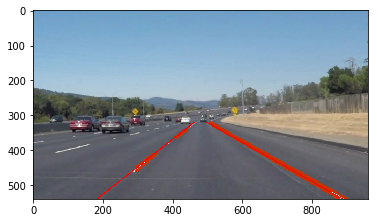

In [1]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

imageLocation = 'test_images/solidWhiteCurve.jpg'
#imageLocation = 'test_images/solidWhiteRight.jpg'
#imageLocation = 'test_images/solidYellowCurve.jpg'
#imageLocation = 'test_images/solidYellowCurve2.jpg'
#imageLocation = 'test_images/solidYellowLeft.jpg'
#imageLocation = 'test_images/whiteCarLaneSwitch.jpg'


#reading in an image, blank out images that aren't correct
image = mpimg.imread(imageLocation)
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)

grayScale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)


#Define Size of the Image
ysize = image.shape[0]
xsize = image.shape[1]


#Define Points on the Image for Region of Interest
p1 = [20, 540]
p2 = [475, 320]
p3 = [510, 320]
p4 = [920,540]



# Define a kernel size and apply Gaussian smoothing
kernel_size = 7
blur_gray = cv2.GaussianBlur(grayScale,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 100
high_threshold = 200
cannyFilteredImage = cv2.Canny(blur_gray, low_threshold, high_threshold)


#Create an Empty Image for Mask
mask = np.zeros_like(cannyFilteredImage)   
ignore_mask_color = 255   

# Define a four sided polygon region to mask in
vertices = np.array([[p1 ,p2 , p3, p4]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
imageWithMaskedEdges = cv2.bitwise_and(cannyFilteredImage, mask)




# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(imageWithMaskedEdges, rho, theta, threshold, np.array([]),
    min_line_length, max_line_gap)

#Initialize Averages Outside of Loop
leftAverageSlope = 0
leftAverageIntercept = 0
rightAverageSlope = 0
rightAverageIntercept = 0
left_Counter = 0
right_Counter = 0


for line in lines:
    for x1,y1,x2,y2 in line:
        #translate the yscale for simplicity
        y1m = abs(ysize - y1)
        y2m = abs(ysize - y2)
        #determine the slope of the line

        slope = ((y1m - y2m)/(x1-x2))
        #Do Line Averaging Here       
        if slope > 0:
            #Line Has positive slope, left lane
            leftAverageSlope += slope
            leftAverageIntercept += -1*(slope*x1-y1m)
            left_Counter += 1
            
        if slope < 0:
            #Line Has negative slope, right lane
            rightAverageSlope += slope
            rightAverageIntercept += -1*(slope*x1-y1m)
            right_Counter += 1
            
            
        cv2.line(image,(x1,y1),(x2,y2),(200,50,0),5)

#Compute Averages
leftAverageSlope = leftAverageSlope/left_Counter
leftAverageIntercept = leftAverageIntercept/left_Counter

rightAverageSlope = rightAverageSlope/right_Counter
rightAverageIntercept = rightAverageIntercept/right_Counter

#DEBUG FOR LINE CHARACTERISTICS
print('Line Characteristics')
print('leftAverageSlope', leftAverageSlope)
print('leftAverageIntercept', leftAverageIntercept)
print('rightAverageSlope', rightAverageSlope)
print('rightAverageIntercept', rightAverageIntercept)

#Calculate Points for Line when y = 0 and y = 220
leftLineXPointOne = (0 - leftAverageIntercept)/leftAverageSlope
leftLineXPointTwo = (220 - leftAverageIntercept)/leftAverageSlope
rightLineXPointOne = (0 - rightAverageIntercept)/rightAverageSlope
rightLineXPointTwo = (220 - rightAverageIntercept)/rightAverageSlope

#Round to Ints
leftLineXPointOne = int(round(leftLineXPointOne))
leftLineXPointTwo = int(round(leftLineXPointTwo))
rightLineXPointOne = int(round(rightLineXPointOne))
rightLineXPointTwo = int(round(rightLineXPointTwo))

#DEBUG FOR LINE CHARACTERISTICS
print('X Point Characteristics')
print ('leftLineXPointOne', leftLineXPointOne, 'leftLineXPointTwo', leftLineXPointTwo)
print ('rightLineXPointOne', rightLineXPointOne, 'rightLineXPointTwo', rightLineXPointTwo)




# Create a "color" binary image to combine with line image
color_edges = np.dstack((grayScale, grayScale, grayScale)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 1, line_image, 1, 0) 


#Plot Lines on Image
cv2.line(image, (leftLineXPointOne,540), (leftLineXPointTwo,320), [255, 0, 0], 2)
cv2.line(image, (rightLineXPointOne,540), (rightLineXPointTwo,320), [255, 0, 0], 2)


#Display Images
#plt.imshow(lines_edges)
plt.imshow(image)


#Save the Images
cv2.imwrite('test_image_output/'+ imageLocation,image)